In [1]:
# Core Geospatial Data Handling:
import rioxarray as rxr # Provides high-level functions for reading, writing, and manipulating geospatial data.
import xarray as xr # raster data, leveraging the power of xarray for labeled multi-dimensional arrays.
from rioxarray.merge import merge_arrays # merge_arrays is specifically imported for combining raster tiles.
import geopandas as gpd # Enables the import, manipulation, and analysis of vector-based geospatial data 
from shapely.geometry import mapping # Facilitates the conversion of vector geometries into a GeoJSON-compliant dictionary

# Fundamental Data Manipulation and Numerical Operations:
import numpy as np # The fundamental package for scientific computing, providing support for efficient 
import pandas as pd # A critical library for data analysis and manipulation, primarily utilised for its

# Primary Geospatial Analysis Function:
from rasterstats import zonal_stats # Fpr calculating zonal statistics, used to aggregate of the raster cell values (population counts).


# Data Visualisation and Cartographic Production:
import matplotlib.pyplot as plt # Imports the primary library for creating static data visualisations and maps.
import matplotlib.patheffects as pe # Provides tools for advanced effects, such as labels.
import matplotlib.patches as mpatches # Used for creating custom legend elements for categorical data.
from matplotlib.colors import ListedColormap # Enables the creation of discrete colormaps.
import mapclassify # Provides a suite of robust algorithms for thematic data classification (e.g., quantiles).

In [5]:
# Define path for Africa-wide Level 1 vector file:
africa_level1 = "data/level1/afr_g2014_2013_1.shp" 
africa_level0 = "data/level0/afr_g2014_2013_0.shp" 
africa_level1_gpf = gpd.read_file(africa_level1)

In [6]:
# Define Paths and Countries:
Country_1_Name = "Uganda"
Country_2_Name = "Rwanda"
Country_3_Name = "Burundi"
Country_4_Name = "United Republic of Tanzania"

# Selected column with Country names:
Country_Column_Name = 'ADM0_NAME' 

In [7]:
# Define paths for raster files:
country1_pop2015 = "data/uga_pop_2015_CN_1km_R2025A_UA_v1.tif"
country2_pop2015 = "data/rwa_pop_2015_CN_1km_R2025A_UA_v1.tif"
country3_pop2015 = "data/bdi_pop_2015_CN_1km_R2025A_UA_v1.tif"
country4_pop2015 = "data/tza_pop_2015_CN_1km_R2025A_UA_v1.tif"
country1_pop2025 = "data/uga_pop_2025_CN_1km_R2025A_UA_v1.tif" 
country2_pop2025 = "data/rwa_pop_2025_CN_1km_R2025A_UA_v1.tif"
country3_pop2025 = "data/bdi_pop_2025_CN_1km_R2025A_UA_v1.tif"
country4_pop2025 = "data/tza_pop_2025_CN_1km_R2025A_UA_v1.tif"

In [10]:
# Data Pre-processing: 
# Load all data:
africa_level1_gdf = gpd.read_file(africa_level1)
africa_level0_gdf = gpd.read_file(africa_level0)
c1_pop2015 = rxr.open_rasterio(country1_pop2015, masked=True).squeeze()
c2_pop2015 = rxr.open_rasterio(country2_pop2015, masked=True).squeeze()
c3_pop2015 = rxr.open_rasterio(country3_pop2015, masked=True).squeeze()
c4_pop2015 = rxr.open_rasterio(country4_pop2015, masked=True).squeeze()    
c1_pop2025 = rxr.open_rasterio(country1_pop2025, masked=True).squeeze()
c2_pop2025 = rxr.open_rasterio(country2_pop2025, masked=True).squeeze()
c3_pop2025 = rxr.open_rasterio(country3_pop2025, masked=True).squeeze()
c4_pop2025 = rxr.open_rasterio(country4_pop2025, masked=True).squeeze()

In [11]:
# Define countries for plotting:
countries_of_interest = [Country_1_Name, Country_2_Name, Country_3_Name, Country_4_Name]
level1_filtered_gdf = africa_level1_gdf[africa_level1_gdf[Country_Column_Name].isin(countries_of_interest)]
level0_filtered_gdf = africa_level0_gdf[africa_level0_gdf[Country_Column_Name].isin(countries_of_interest)]

In [12]:
# Merge the rasters for individual year:
merged_pop2015 = merge_arrays([c1_pop2015, c2_pop2015, c3_pop2015, c4_pop2015])
merged_pop2025 = merge_arrays([c1_pop2025, c2_pop2025, c3_pop2025, c4_pop2025])

In [13]:
# Reproject to new CRS:  
dst_crs = "ESRI:102022" # Africa Albers Equal Area Conic

# Reproject the GeoDataFrame:
level1_proj_gdf = level1_filtered_gdf.to_crs(dst_crs)
level0_proj_gdf = level0_filtered_gdf.to_crs(dst_crs)

# Reproject the merged rasters:
pop2015_proj = merged_pop2015.rio.reproject(dst_crs)
pop2025_proj = merged_pop2025.rio.reproject(dst_crs)

In [14]:
# Checking the new CRS:
print(f"CRS of reprojected Level 1 GDF: {level1_proj_gdf.crs}")
print(f"CRS of reprojected Level 0 GDF: {level0_proj_gdf.crs}")
print(f"CRS of reprojected 2015 Population Raster: {pop2015_proj.rio.crs}")
print(f"CRS of reprojected 2025 Population Raster: {pop2025_proj.rio.crs}")

# Saving the processed rasters: Suitable for zonal_stats.
pop2015_proj_path = "data/temp_pop2015_proj.tif"
pop2025_proj_path = "data/temp_pop2025_proj.tif"

CRS of reprojected Level 1 GDF: ESRI:102022
CRS of reprojected Level 0 GDF: ESRI:102022
CRS of reprojected 2015 Population Raster: ESRI:102022
CRS of reprojected 2025 Population Raster: ESRI:102022


In [15]:
# Loading new projected rasters:
pop2015_proj.rio.to_raster(pop2015_proj_path)
pop2025_proj.rio.to_raster(pop2025_proj_path)

#### Zonal Statistics and Visualization:

In [16]:
# a) Calculating total population count:
stats_2015 = zonal_stats(level1_proj_gdf, pop2015_proj_path, stats="sum")
stats_2025 = zonal_stats(level1_proj_gdf, pop2025_proj_path, stats="sum")

In [17]:
# b) Adding population sum to a new column in the geodataframe:
level1_proj_gdf['pop_2015_sum'] = [s['sum'] for s in stats_2015]
level1_proj_gdf['pop_2025_sum'] = [s['sum'] for s in stats_2025]

In [24]:
# Population Change: Categorical
# Calculating population change:
population_change_raster = pop2025_proj - pop2015_proj

population_threshold = 1
mask = pop2015_proj >= population_threshold

# xarray.where() keeps the original value of the rasters points where the condition is True.
masked_change_raster = population_change_raster.where(mask)

In [31]:
# Define categories and reclassify the MASKED raster:
# Changing values for the masked area:
change_values = masked_change_raster.values

# Defining the categories and reclassify the raster using the conditions:
conditions = [
    (change_values < 0),                                # 1: Decline
    (change_values == 0),                               # 2: Neutral
    ((change_values > 0) & (change_values <= 50)),      # 3: Growth
    (change_values > 50)                                # 4: High Growth
]

# Defining the corresponding category values:
choices = [1, 2, 3, 4]

# Reclassifying using np:
reclassified_change = np.select(conditions, choices, default=np.nan) # default=0 for no data

# Assigning reclassified values back into an xarray.DataArray with the right coordinates:
reclassified_raster = xr.DataArray(
    reclassified_change,
    coords=masked_change_raster.coords,
    dims=masked_change_raster.dims,
    attrs=masked_change_raster.attrs
)
reclassified_raster.rio.write_nodata(np.nan, inplace=True)
print("Raster files has been reclassified into 4 categories.")

Raster files has been reclassified into 4 categories.


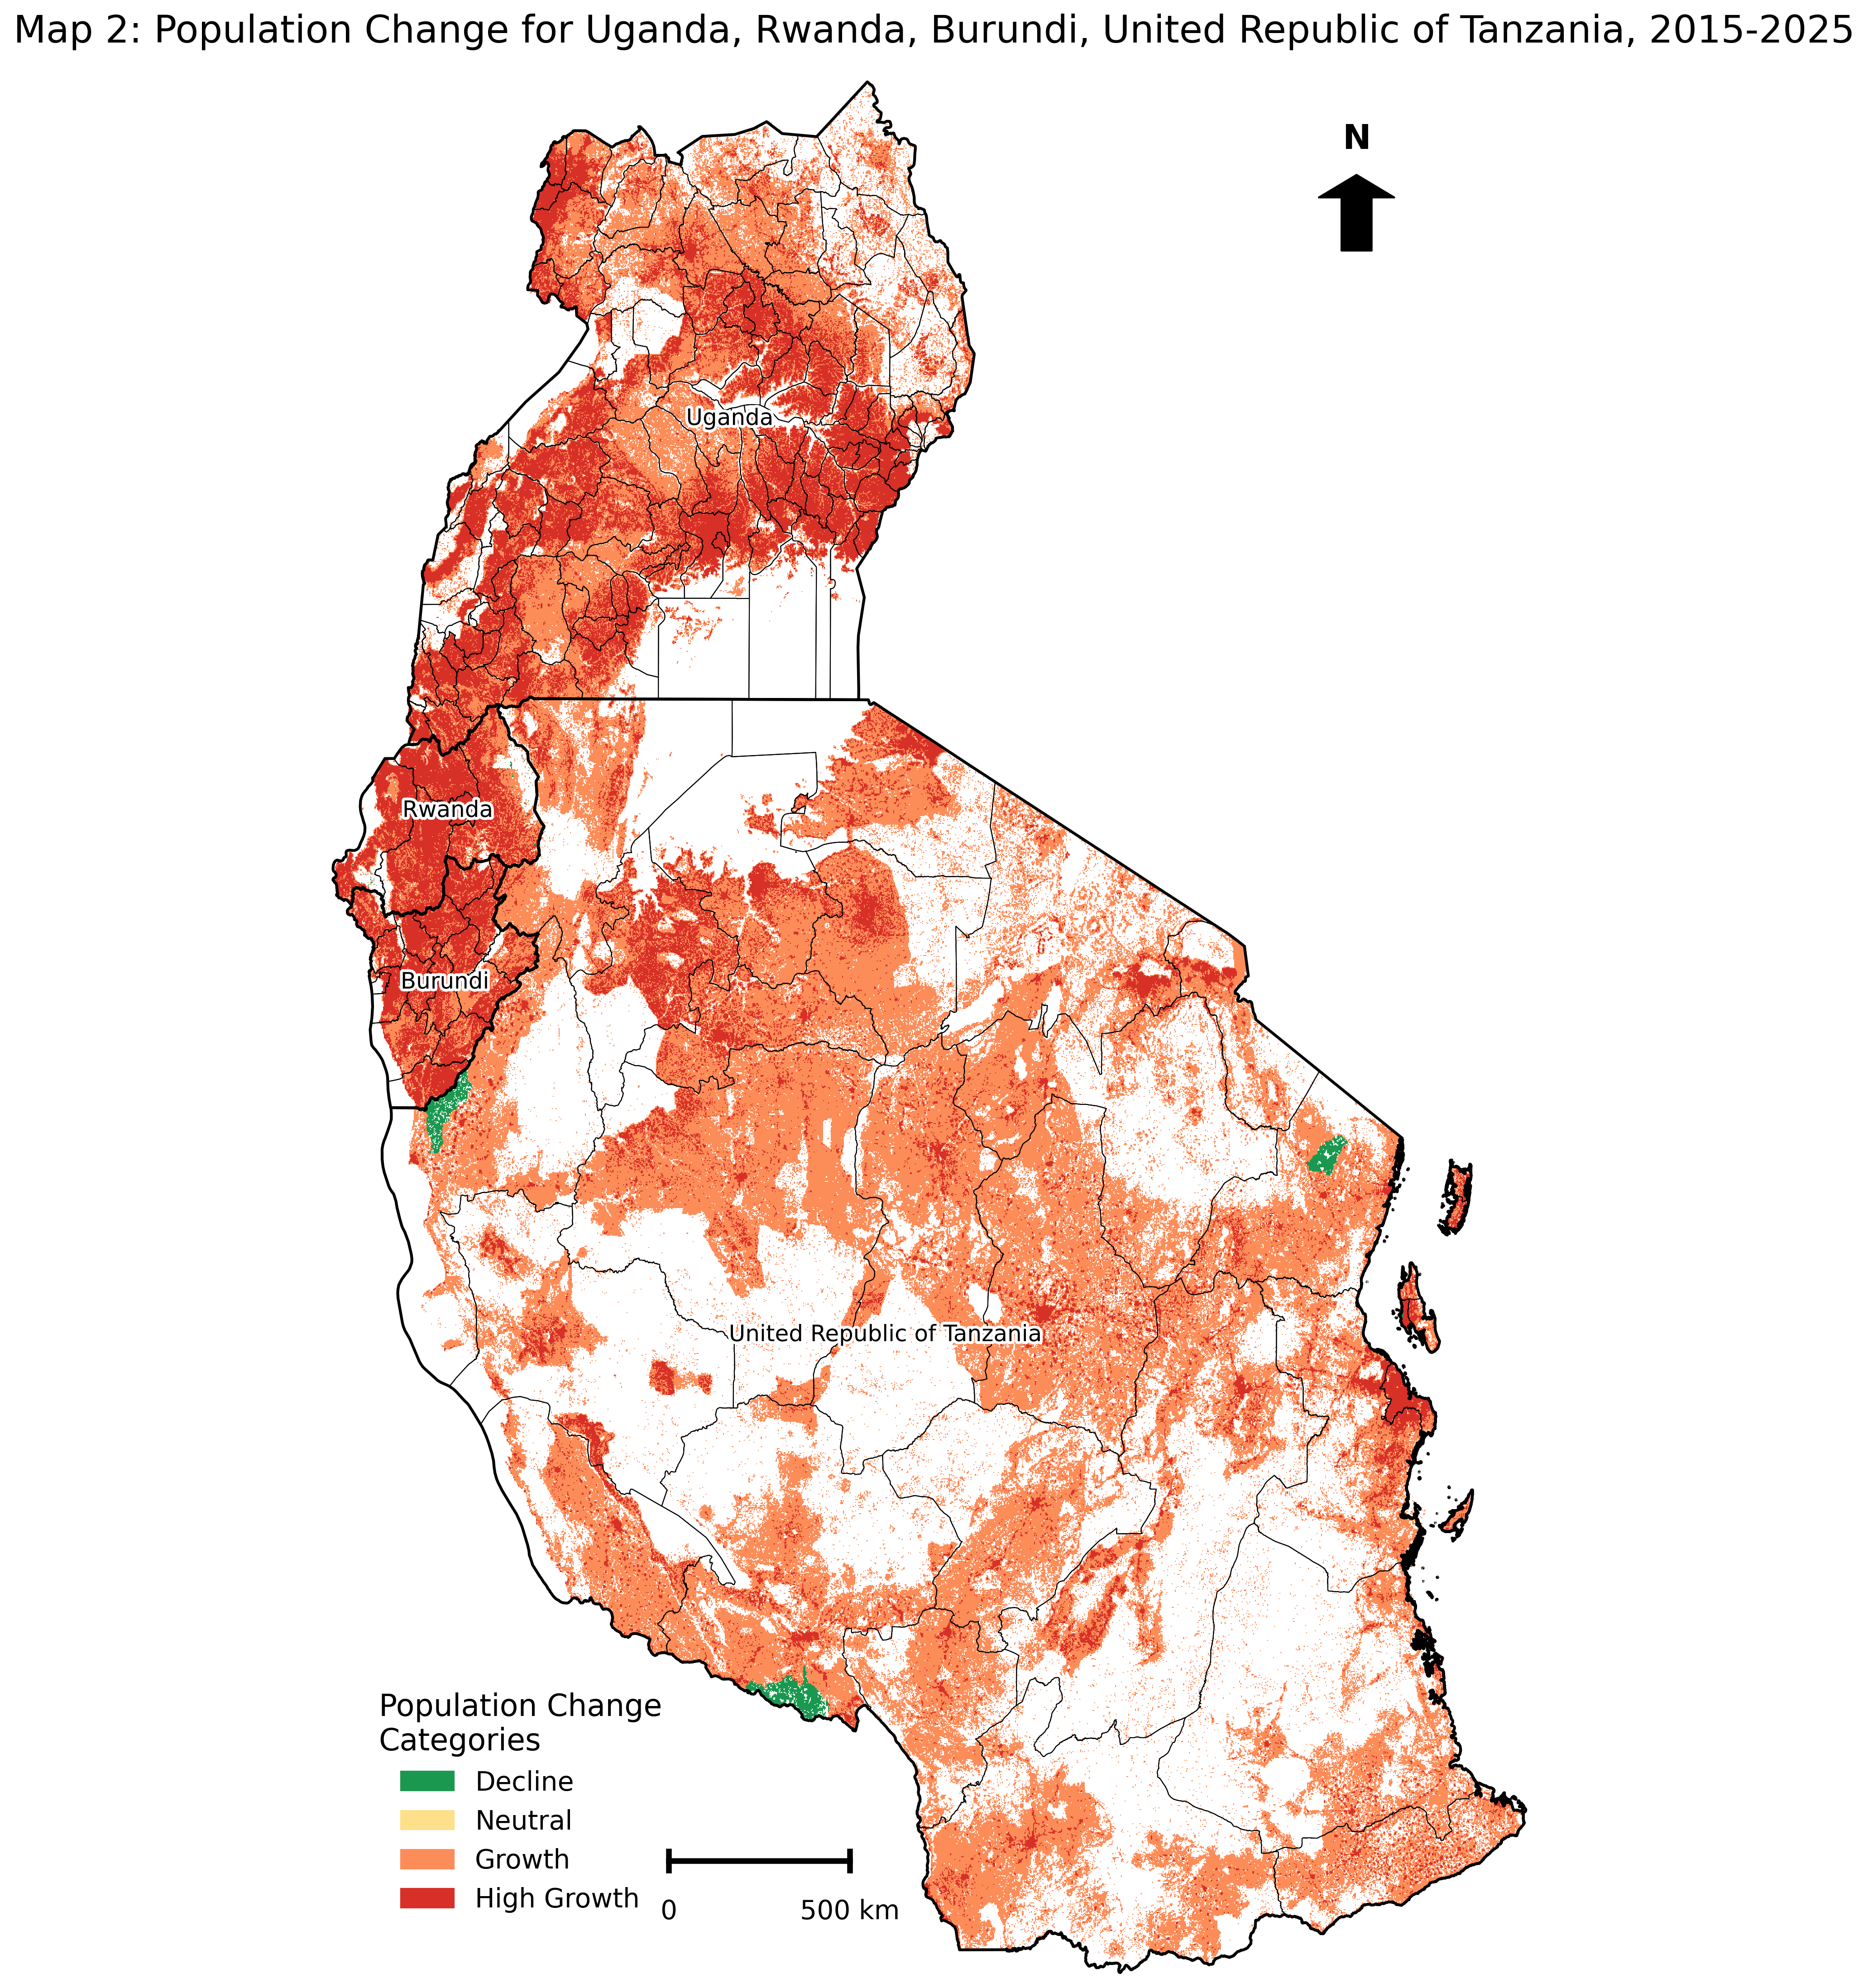

In [58]:
# Plotting Population Chnage Map:
# Defining layout size and resolution:
fig, ax = plt.subplots(1, 1, figsize=(15, 15), dpi=300)

# Defining color scheme and labels:
cmap_change = ListedColormap(['#1a9850','#fee08b', '#fc8d59','#d73027'])
labels = ['Decline', 'Neutral', 'Growth', 'High Growth']

# Plotting the main data layers:
reclassified_raster.plot(ax=ax, cmap=cmap_change, add_colorbar=False)
level1_proj_gdf.boundary.plot(ax=ax, edgecolor='black', linewidth=0.5)
level0_proj_gdf.plot(ax=ax, edgecolor='black', facecolor='none', linewidth=1.5)

# Adding country name labels:
for idx, row in level0_proj_gdf.iterrows():
    point = row.geometry.representative_point()
    ax.annotate(text=row['ADM0_NAME'], xy=(point.x, point.y),
                ha='center', va='center', fontsize=12,
                path_effects=[pe.withStroke(linewidth=3, foreground="white")])

# Defining legends properties:
patches = [mpatches.Patch(color=cmap_change.colors[i], label=labels[i]) for i in range(len(labels))]
ax.legend(handles=patches,
          title="Population Change\nCategories",
          loc='lower left', # position of legend
          bbox_to_anchor=(0.02, 0.02),  
          ncol=1, # Number of columns for legends
          frameon=False, # No frame
          facecolor='white', # White background
          fontsize=14, # Fontsize of legends
          title_fontsize=16) # Fontsize of legend title

#  North arrow and scale bar:
def add_north_arrow(ax, xpos=0.85, ypos=0.95, arrow_length=0.04, head_width=40, body_width=16): # Dimensions and position
    ax.annotate('', xy=(xpos, ypos),
                xytext=(xpos, ypos - arrow_length),
                arrowprops=dict(facecolor='black', width=body_width, headwidth=head_width),
                ha='center', va='center',
                xycoords=ax.transAxes)
    ax.text(xpos, ypos + 0.01, 'N',
            ha='center', va='bottom',
            fontsize= 18,
            fontweight='bold',
            transform=ax.transAxes)

def add_scale_bar(ax, length_km=500, location=(0.095, 0.18)): # Size and position of scale bar
    x0, y0 = location
    bar_height = 0.005
    # Main scale bar line
    ax.plot([x0, x0 + 0.15], [y0, y0], color='black', lw=3, transform=ax.transAxes)
    # Ticks at ends
    ax.plot([x0, x0], [y0 - bar_height, y0 + bar_height], color='black', lw=3, transform=ax.transAxes)
    ax.plot([x0 + 0.15, x0 + 0.15], [y0 - bar_height, y0 + bar_height], color='black', lw=3, transform=ax.transAxes)
    # Labels
    ax.text(x0, y0 - 0.02, '0', transform=ax.transAxes, ha='center', va='top', fontsize=14)
    ax.text(x0 + 0.15, y0 - 0.02, f'{length_km} km', transform=ax.transAxes, ha='center', va='top', fontsize=14)

add_north_arrow(ax)
add_scale_bar(ax, length_km=500, location=(0.28, 0.060))

ax.set_title(f'Map 2: Population Change for Uganda, Rwanda, Burundi, United Republic of Tanzania, 2015-2025', fontsize=20, pad=20)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_axis_off()

plt.subplots_adjust(left=0.02, right=0.98, top=0.95, bottom=0.02)
plt.savefig("population_change_map_final_inset_layout.png", dpi=300, bbox_inches='tight')

plt.show() # Display map